In [1]:
import codecs
import argparse
import datetime as dt
import psycopg2
import psycopg2.extras
from sets import Set
import pandas as pd
import re
from db import sql2df
%pylab inline

/Users/peterzvirinsky/Envs/GraphSlices/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: the sets module is deprecated
  


Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_senate(reference_number):
    matcher = re.search('([A-Z]+) ([0-9]+) INS .*', reference_number)
    if not matcher:
        return None    
    return matcher.group(1) + "-" + matcher.group(2)

assert get_senate('KSPL 27 INS 2047 / 2014') == 'KSPL-27'

# Nodes

In [3]:
creditor_df = sql2df(
    "SELECT creditor_string_id AS id, max(creditor) as name, count(*) as count  \
     FROM v_creditors_receivables ft \
     GROUP BY creditor_string_id \
     ORDER BY count DESC \
     LIMIT 100"
).drop_duplicates().drop(labels=["count"], axis=1)
creditor_df["type"] = "creditor"
creditor_df.shape

(100, 3)

In [4]:
creditor_ids = list(creditor_df["id"].values)

In [5]:
administrators_df = sql2df(
    "SELECT at.id AS id, at.name AS name \
    FROM administrators_tab at \
    JOIN insolvencies_administrators_tab iat ON iat.administrator_id=at.id \
    JOIN (SELECT it.id \
        FROM insolvency_tab it \
              JOIN v_creditors_receivables ft2 ON it.id=ft2.insolvency_id \
        WHERE ft2.creditor_string_id is not null \
              AND ft2.creditor_string_id = ANY(%(creditor_ids)s) \
        GROUP BY it.id) as its \
    ON iat.insolvency_id=its.id \
    GROUP BY at.id, at.name", {"creditor_ids": creditor_ids}
).drop_duplicates()
administrators_df["id"] = administrators_df["id"].apply(lambda id_: "adm_%d" % id_)
administrators_df["type"] = "administrator"
administrators_df.shape

(877, 3)

In [6]:
insolvencies_df = sql2df(
    "SELECT it3.id AS id, it3.debtor_name AS name, it3.person_type AS person_type, \
            it3.reference_number AS reference_number, it3.region_id AS region_id, \
            it3.proposal_timestamp::DATE AS date\
        FROM insolvency_tab it3  \
        JOIN (SELECT it.id \
              FROM insolvency_tab it \
                   JOIN v_creditors_receivables ft2 ON it.id=ft2.insolvency_id \
              WHERE ft2.creditor_string_id is not null \
                   AND ft2.creditor_string_id = ANY(%(creditor_ids)s) \
              GROUP BY it.id) as insolvencies \
        ON it3.id=insolvencies.id", {"creditor_ids": creditor_ids}
).drop_duplicates()
insolvencies_df["type"] = "debtor"
insolvencies_df = insolvencies_df[insolvencies_df["date"] < datetime.date(2018, 1, 1)].copy()
insolvencies_df.shape

(151833, 7)

In [7]:
nodes_df = creditor_df.append(administrators_df).append(
    insolvencies_df.drop(labels=["reference_number"], axis=1)
)
nodes_df = nodes_df[["id", "name", "person_type", "region_id", "type", "date"]]
nodes_df.shape
node_ids = set(nodes_df["id"].values)

# Edges

In [8]:
insolvency_administrator_edges_df = sql2df(
    "SELECT it.id AS insolvency_id, iat.administrator_id, start_date::DATE, end_date::DATE \
     FROM insolvencies_administrators_tab iat JOIN insolvency_tab it ON iat.insolvency_id=it.id"
).drop_duplicates()

insolvency_administrator_edges_df["administrator_id"] = insolvency_administrator_edges_df["administrator_id"].apply(
    lambda id_: "adm_%d" % id_
)

insolvency_administrator_edges_df["type"] = "ins_adm"
insolvency_administrator_edges_df.shape

(192316, 5)

In [9]:
insolvency_end_dates_df = sql2df(
    "SELECT insolvency_id, MAX(state_change_timestamp)::DATE AS end_date \
     FROM current_insolvency_states_tab WHERE state = 9 GROUP BY insolvency_id"
)

In [10]:
insolvency_creditor_edges_df = sql2df(
    "SELECT insolvency_id, creditor_string_id AS creditor_id, proposal_timestamp::DATE AS start_date \
     FROM v_creditors_receivables \
          JOIN insolvency_tab it ON insolvency_id=it.id \
     WHERE creditor_string_id is not null"
).drop_duplicates()

insolvency_creditor_edges_df = insolvency_creditor_edges_df.merge(
    insolvency_end_dates_df, left_on="insolvency_id", right_on="insolvency_id", how="left"
)
insolvency_creditor_edges_df["type"] = "ins_cred"
insolvency_creditor_edges_df.shape

(1564186, 5)

In [11]:
insolvency_insolvency_edges_df = sql2df(
    "SELECT it1.id AS insolvency_id1, it2.id AS insolvency_id2, it1.proposal_timestamp::DATE AS date \
     FROM insolvency_tab it1 JOIN insolvency_tab it2 ON it1.debtor_address = it2.debtor_address \
     WHERE it1.debtor_address is not null  \
           AND it2.debtor_address is not null \
           AND it1.debtor_name <> it2.debtor_name \
           AND it1.id <> it2.id"
).drop_duplicates()
insolvency_insolvency_edges_df["type"] = "ins_ins"
insolvency_insolvency_edges_df.shape

(3514870, 4)

In [12]:
insolvencies_df["senate"] = insolvencies_df["reference_number"].apply(get_senate)

senate_insolvency_edges_df = insolvencies_df[
    insolvencies_df["senate"].notnull()
][["id", "senate", "date"]].rename(columns={"id": "source_id", "senate": "target_id", "date": "start_date"})

senate_insolvency_edges_df = senate_insolvency_edges_df.merge(
    insolvency_end_dates_df, left_on="source_id", right_on="insolvency_id", how="left"
).drop("insolvency_id", axis=1)
senate_insolvency_edges_df["type"] = "sen_ins"

In [13]:
edges_df = insolvency_administrator_edges_df.rename(
    columns={"insolvency_id": "source_id", "administrator_id": "target_id"}
).append(
    insolvency_creditor_edges_df.rename(
        columns={"insolvency_id": "source_id", "creditor_id": "target_id"}
    )
).append(senate_insolvency_edges_df)
# .append(
#     insolvency_insolvency_edges_df.rename(
#         columns={"insolvency_id1": "srcId", "insolvency_id2": "dstId"}
#     )
# )
edges_df.apply(lambda row: row["source_id"] in node_ids and row["target_id"] in node_ids, axis=1)
edges_df = edges_df[["source_id", "target_id", "type", "start_date", "end_date"]]
edges_df.shape

(1908293, 5)

In [14]:
assert nodes_df["id"].isnull().sum() == 0
assert edges_df["source_id"].isnull().sum() == 0
assert edges_df["target_id"].isnull().sum() == 0

In [15]:
# remove deg 0 nodes
edge_node_ids = set(edges_df["source_id"].values).union(set(edges_df["target_id"].values))
nodes_df = nodes_df[nodes_df["id"].apply(lambda id_: id_ in edge_node_ids)]
nodes_df.shape

(152810, 6)

# Stats

In [16]:
nodes_df.groupby("type").count()[["id"]]

,id
type,
administrator,877
creditor,100
debtor,151833


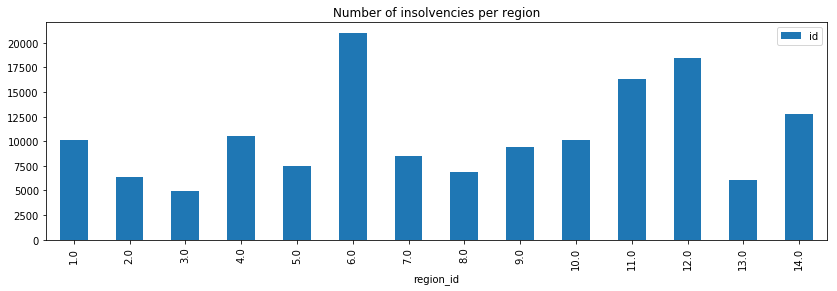

In [17]:
nodes_df.groupby("region_id").count()[["id"]].plot(kind="bar", title="Number of insolvencies per region", figsize=(14,4))

In [18]:
debtor_nodes = nodes_df[nodes_df["type"] == "debtor"].copy()
debtor_nodes["day_month"] = debtor_nodes["date"].apply(lambda d: d.replace(day=1))

In [19]:
ins_per_month = debtor_nodes.groupby("day_month").count()["id"].sort_index()

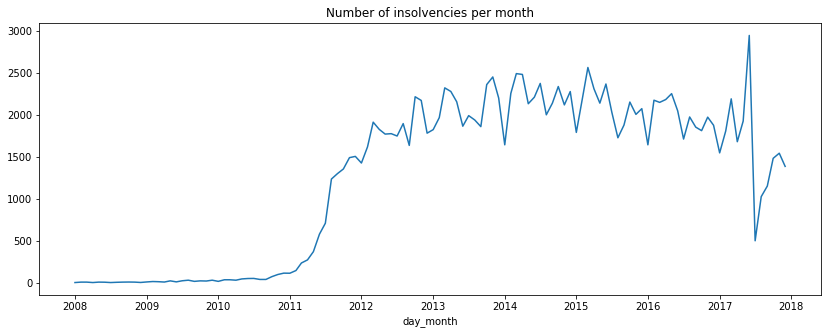

In [20]:
ins_per_month.plot(figsize=(14,5), title="Number of insolvencies per month")

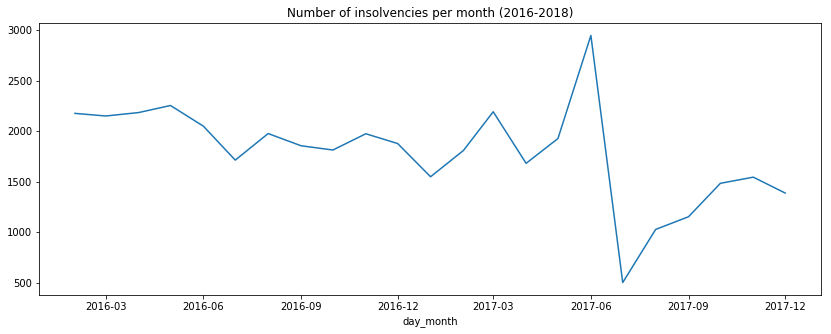

In [21]:
ins_per_month[ins_per_month.index > datetime.date(2016, 1, 1)].plot(figsize=(14,5), title="Number of insolvencies per month (2016-2018)")

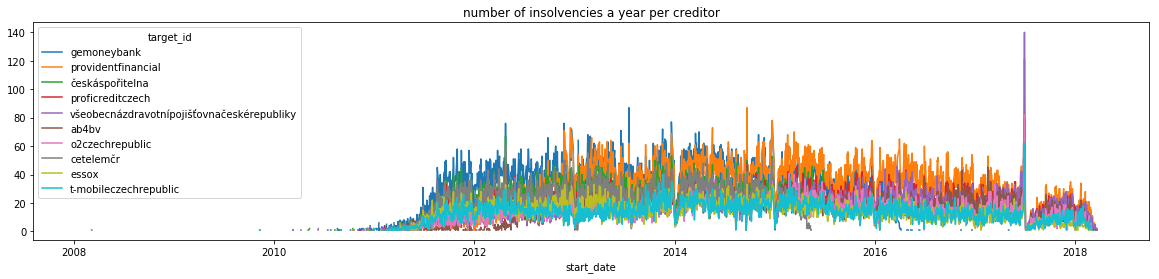

In [26]:
ins_cred_edges_df = edges_df[edges_df["type"] == "ins_cred"].copy()
ins_cred_edges_df["start_date_day_month"] = ins_cred_edges_df["start_date"].apply(lambda d: d.replace(day=1))
cred_ins_per_month = ins_cred_edges_df.groupby(["target_id", "start_date"]).count().reset_index().pivot_table(values="source_id", index="target_id", columns="start_date")
cred_ins_per_month.loc[creditor_df[0:10]["id"].values].T.plot(figsize=(20, 4), title="number of insolvencies a year per creditor")

# Saving dataset

In [23]:
timestamp_str = datetime.datetime.now().strftime("%Y_%m_%d")

In [24]:
nodes_df.to_csv("data/isir/nodes_%s.tsv" % timestamp_str, 
                sep="\t", encoding="utf-8", index=False)

In [25]:
edges_df.to_csv("data/isir/edges_%s.tsv" % timestamp_str, 
                 sep="\t", encoding="utf-8", index=False)